Churn Prediction Via customer Segmentation




In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

In [10]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [11]:
data_with_id = data.copy()

In [12]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)

In [13]:
data = data.drop(columns=['customerID'])

In [14]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [15]:
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_cluster = data[cluster_features]

In [16]:
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

In [17]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)


In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('elbow_curve.png')
plt.close()

In [19]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

In [20]:
cluster_analysis = data.groupby('Cluster')[cluster_features].mean()
print("Cluster Analysis:")
print(cluster_analysis)

Cluster Analysis:
            tenure  MonthlyCharges  TotalCharges
Cluster                                         
0        53.191623       28.391937   1485.135550
1        65.222222       99.020414   6447.067019
2         9.867112       31.608586    295.609223
3        11.805830       79.516736    931.631858
4        46.418773       80.772960   3646.253755


In [21]:
centroids_scaled = kmeans.cluster_centers_
centroids = scaler_cluster.inverse_transform(centroids_scaled)

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

In [23]:
scatter = ax.scatter(
    data['tenure'],
    data['MonthlyCharges'],
    data['TotalCharges'],
    c=data['Cluster'],
    cmap='viridis',
    alpha=0.6,
    label='Customers'
)

In [24]:
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    c='red',
    marker='*',
    s=300,
    label='Centroids'
)

In [25]:
ax.set_xlabel('Tenure')
ax.set_ylabel('Monthly Charges')
ax.set_zlabel('Total Charges')
ax.set_title('3D Clusters and Centroids')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.savefig('cluster_3d_plot.png')
plt.close()

<ipython-input-25-86abf47a9050>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-25-86abf47a9050>:6: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Cluster')


In [26]:
X = data.drop(columns=['Churn'])
y = data['Churn']


In [27]:
scaler_churn = StandardScaler()
# Fit and transform the features (X) before splitting
X_scaled = scaler_churn.fit_transform(X)

# Step 5: Train-Test Split (using scaled features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Apply SMOTE to Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 7: Train Churn Prediction Models
# Logistic Regression (using resampled data)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

# Gradient Boosting (using resampled data)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

In [28]:
print("\nLogistic Regression Performance (with SMOTE):")
print(classification_report(y_test, lr_pred))
print("AUC-ROC:", roc_auc_score(y_test, lr_prob))


Logistic Regression Performance (with SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1036
           1       0.53      0.83      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409

AUC-ROC: 0.8609999792975664


In [29]:
print("\nGradient Boosting Performance (with SMOTE):")
print(classification_report(y_test, gb_pred))
print("AUC-ROC:", roc_auc_score(y_test, gb_prob))


Gradient Boosting Performance (with SMOTE):
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1036
           1       0.59      0.75      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.76      1409
weighted avg       0.82      0.79      0.80      1409

AUC-ROC: 0.8573537631848624


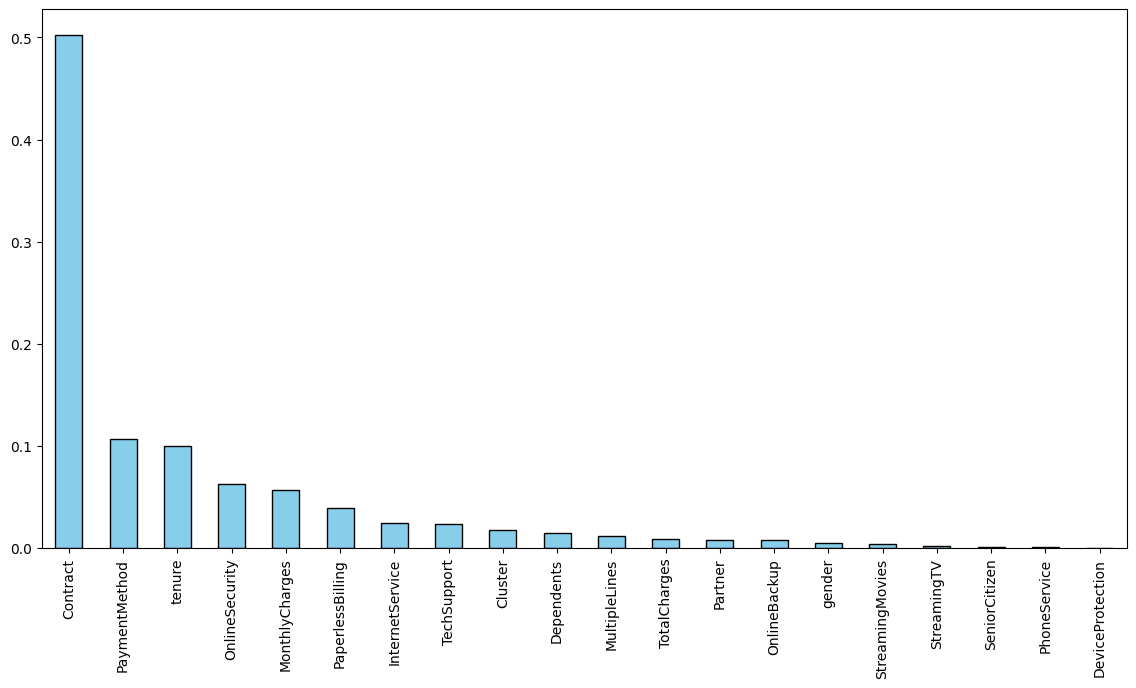

In [30]:
plt.figure(figsize=(14, 7))  # wider frame for long feature names
feature_importance.plot(kind='bar', color='skyblue', edgecolor='black')

plt.figure(figsize=(16, 8))  # wider and taller
feature_importance.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Feature Importance (Gradient Boosting with SMOTE)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(bottom=0.25)  # <-- more space below x-axis
plt.savefig('feature_importance_fixed.png', bbox_inches='tight', dpi=300)
plt.close()

In [ ]:
print("\nEnter a customerID to predict churn (e.g., '7590-VHVEG'):")
customer_id = input().strip()

# Find the customer in the original dataset
customer_data = data_with_id[data_with_id['customerID'] == customer_id]

if customer_data.empty:
    print(f"CustomerID '{customer_id}' not found in the dataset.")
else:
    # Prepare the customer data for prediction
    customer_data_processed = customer_data.copy()
    customer_data_processed['TotalCharges'] = pd.to_numeric(customer_data_processed['TotalCharges'], errors='coerce').fillna(0)
    customer_data_processed = customer_data_processed.drop(columns=['customerID'])

    # Encode categorical variables using the same label encoders
    for column in customer_data_processed.select_dtypes(include=['object']).columns:
        if column in label_encoders:
            customer_data_processed[column] = label_encoders[column].transform(customer_data_processed[column])

    # Add cluster label
    customer_cluster_features = customer_data_processed[cluster_features]
    customer_cluster_scaled = scaler_cluster.transform(customer_cluster_features)
    customer_data_processed['Cluster'] = kmeans.predict(customer_cluster_scaled)

    # Prepare features for prediction
    customer_features = customer_data_processed.drop(columns=['Churn'])
    # Scale the customer features using the same scaler used for training
    customer_features_scaled = scaler_churn.transform(customer_features)
    # Convert to NumPy array to remove feature names (fix the warning)
    customer_features_scaled = customer_features_scaled  # Already a NumPy array from scaler.transform

    # Predict churn using Gradient Boosting
    churn_prediction = gb_model.predict(customer_features_scaled)
    churn_probability = gb_model.predict_proba(customer_features_scaled)[0, 1]

    # Display result
    churn_result = "Yes" if churn_prediction[0] == 1 else "No"
    print(f"\nCustomerID: {customer_id}")
    print(f"Predicted Churn: {churn_result}")
    print(f"Probability of Churn: {churn_probability:.2%}")